In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

class CircleTaskDistribution:
    def __init__(self):
        self.radius = 2.0
        self.range_x = [-5, 5]
        self.center_range = [-3, 3]

    def sample_task(self):
        cx = np.random.uniform(self.center_range[0], self.center_range[1])
        cy = np.random.uniform(self.center_range[0], self.center_range[1])
        return (cx, cy)

    def sample_data(self, task_center, k_samples):
        x = np.random.uniform(self.range_x[0], self.range_x[1], (k_samples, 2))

        cx, cy = task_center
        dist_sq = (x[:, 0] - cx)**2 + (x[:, 1] - cy)**2
        y = (dist_sq < self.radius**2).astype(np.float32)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

def maml_train(meta_epochs=2000, alpha=0.1, beta=0.001, k_shot=10):
    model = SimpleMLP()
    meta_optimizer = optim.Adam(model.parameters(), lr=beta)
    task_dist = CircleTaskDistribution()
    loss_fn = nn.BCELoss()

    
    for epoch in range(meta_epochs):
        meta_optimizer.zero_grad()
        meta_batch_loss = 0.0


        batch_size = 16
        for _ in range(batch_size):
            center = task_dist.sample_task()
            x_supp, y_supp = task_dist.sample_data(center, k_shot)
            x_query, y_query = task_dist.sample_data(center, k_shot)

            current_params = dict(model.named_parameters())

            # Forward pass on support set
            preds_supp = model(x_supp)
            loss_supp = loss_fn(preds_supp, y_supp)

            # Compute gradients for inner update
            grads = torch.autograd.grad(loss_supp, model.parameters(), create_graph=True)

            fast_weights = {}
            for (name, param), grad in zip(current_params.items(), grads):
                fast_weights[name] = param - alpha * grad


            preds_query = functional_forward(x_query, fast_weights)
            task_query_loss = loss_fn(preds_query, y_query)

            meta_batch_loss += task_query_loss

        # 3. Meta-Update: Update the INITIAL parameters
        meta_batch_loss /= batch_size
        meta_batch_loss.backward()
        meta_optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Meta Loss {meta_batch_loss.item():.4f}")

    return model

In [3]:
def baseline_train(epochs=2000, lr=0.001):
    model = SimpleMLP()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    task_dist = CircleTaskDistribution()

    for epoch in range(epochs):
        optimizer.zero_grad()

        x_batch = []
        y_batch = []
        for _ in range(32):
            center = task_dist.sample_task()
            bx, by = task_dist.sample_data(center, 10)
            x_batch.append(bx)
            y_batch.append(by)

        x_batch = torch.cat(x_batch)
        y_batch = torch.cat(y_batch)

        preds = model(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()

    return model

In [6]:
# Initialize the task distribution
task_dist = CircleTaskDistribution()
K_SHOT = 10

# 1. Train the MAML model
maml_model = maml_train(meta_epochs=2000, k_shot=K_SHOT)

# 2. Train the Baseline model
baseline_model = baseline_train(epochs=2000)

Starting Meta-Training...
Epoch 0: Meta Loss 0.5414
Epoch 100: Meta Loss 0.3159
Epoch 200: Meta Loss 0.3060
Epoch 300: Meta Loss 0.2627
Epoch 400: Meta Loss 0.3333
Epoch 500: Meta Loss 0.2757
Epoch 600: Meta Loss 0.3279
Epoch 700: Meta Loss 0.2380
Epoch 800: Meta Loss 0.2589
Epoch 900: Meta Loss 0.4304
Epoch 1000: Meta Loss 0.2678
Epoch 1100: Meta Loss 0.2421
Epoch 1200: Meta Loss 0.2530
Epoch 1300: Meta Loss 0.2937
Epoch 1400: Meta Loss 0.2676
Epoch 1500: Meta Loss 0.2462
Epoch 1600: Meta Loss 0.3568
Epoch 1700: Meta Loss 0.2539
Epoch 1800: Meta Loss 0.2664
Epoch 1900: Meta Loss 0.2488


Test Task Center: (1.6726098704602839, -1.5452280855014582)


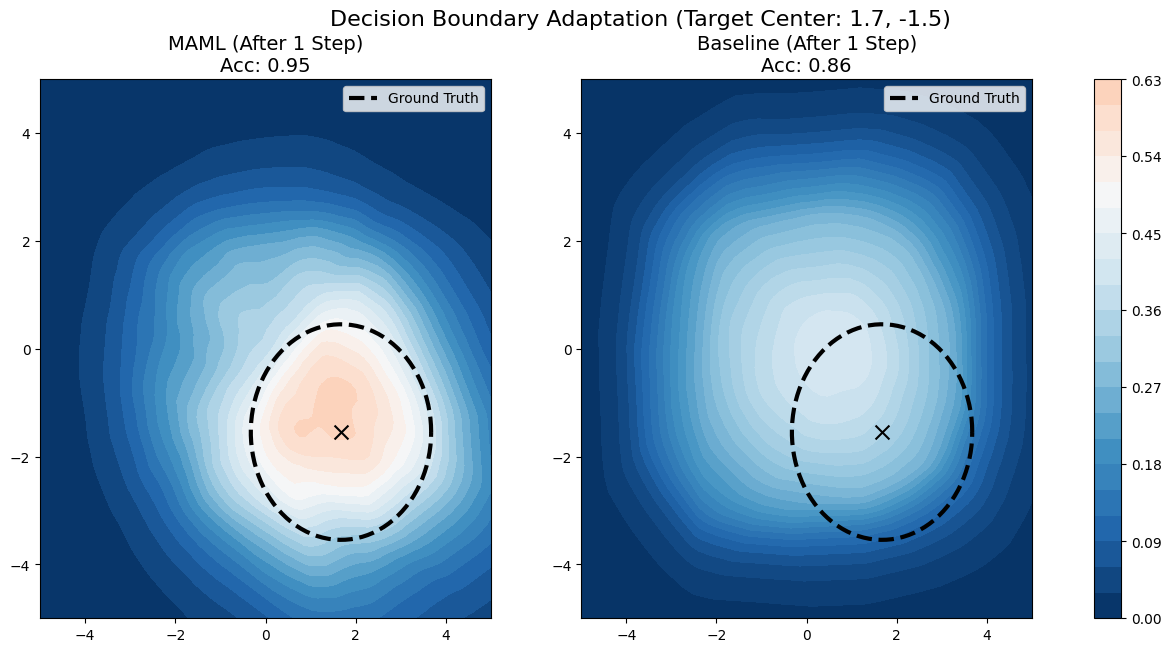

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy


def functional_forward(x, params):
    """
    Manually computes the forward pass of SimpleMLP using a dictionary of parameters.
    Necessary for MAML's inner loop updates.
    """
    # Layer 1: Linear -> ReLU
    x = F.linear(x, params['net.0.weight'], params['net.0.bias'])
    x = F.relu(x)

    # Layer 2: Linear -> ReLU
    x = F.linear(x, params['net.2.weight'], params['net.2.bias'])
    x = F.relu(x)

    # Layer 3: Linear -> Sigmoid
    x = F.linear(x, params['net.4.weight'], params['net.4.bias'])
    x = torch.sigmoid(x)
    return x


def evaluate_maml(model, task_center, steps=10, k_shot=10, lr=0.1):
    """
    Fine-tunes the MAML model using manual weight updates.
    """
    task_dist = CircleTaskDistribution()
    loss_fn = nn.BCELoss()

    # Generate Data
    x_supp, y_supp = task_dist.sample_data(task_center, k_shot)
    x_test, y_test = task_dist.sample_data(task_center, 1000)

    # 1. Clone weights
    current_params = {name: p.clone().detach().requires_grad_(True) for name, p in model.named_parameters()}

    accuracies = []

    with torch.no_grad():
        preds = functional_forward(x_test, current_params)
        acc = ((preds > 0.5) == y_test).float().mean().item()
        accuracies.append(acc)

    # Fine-tuning
    for _ in range(steps):
        # Forward pass on Support Set using current_params
        preds_supp = functional_forward(x_supp, current_params)
        loss = loss_fn(preds_supp, y_supp)

        # Compute Gradients
        grads = torch.autograd.grad(loss, current_params.values())

        # Manual Update: theta' = theta - alpha * grads
        new_params = {}
        for (name, param), grad in zip(current_params.items(), grads):
            new_params[name] = param - lr * grad
        current_params = new_params

        # Evaluate on Test Set
        with torch.no_grad():
            preds_test = functional_forward(x_test, current_params)
            acc = ((preds_test > 0.5) == y_test).float().mean().item()
            accuracies.append(acc)

    return accuracies, current_params

def evaluate_baseline(model, task_center, steps=10, k_shot=10, lr=0.1):
    """
    Fine-tunes the Baseline model using standard optimizer.
    """
    task_dist = CircleTaskDistribution()
    loss_fn = nn.BCELoss()

    x_supp, y_supp = task_dist.sample_data(task_center, k_shot)
    x_test, y_test = task_dist.sample_data(task_center, 1000)

    # Deep copy to avoid modifying the original baseline
    model_copy = copy.deepcopy(model)
    optimizer = optim.SGD(model_copy.parameters(), lr=lr)

    accuracies = []

    # Step 0: Pre-update accuracy
    with torch.no_grad():
        preds = model_copy(x_test)
        acc = ((preds > 0.5) == y_test).float().mean().item()
        accuracies.append(acc)

    # Steps 1 to 10: Fine-tuning
    for _ in range(steps):
        optimizer.zero_grad()
        preds_supp = model_copy(x_supp)
        loss = loss_fn(preds_supp, y_supp)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds_test = model_copy(x_test)
            acc = ((preds_test > 0.5) == y_test).float().mean().item()
            accuracies.append(acc)

    return accuracies, model_copy



task_dist = CircleTaskDistribution()
K_SHOT = 10
test_center = task_dist.sample_task()# Sample a random new task
print(f"Test Task Center: {test_center}")


# Generate Grid
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(x_range, y_range)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Get 1-Step Models
maml_acc, maml_params_1step = evaluate_maml(maml_model, test_center, steps=1, k_shot=K_SHOT)
base_acc, base_model_1step = evaluate_baseline(baseline_model, test_center, steps=1, k_shot=K_SHOT)

# Predict
with torch.no_grad():
    # MAML (Using functional forward)
    maml_preds = functional_forward(grid_tensor, maml_params_1step).reshape(xx.shape)
    # Baseline (Standard forward)
    base_preds = base_model_1step(grid_tensor).reshape(xx.shape)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Ground Truth Circle
theta = np.linspace(0, 2*np.pi, 100)
gt_x = test_center[0] + 2.0 * np.cos(theta)
gt_y = test_center[1] + 2.0 * np.sin(theta)

# MAML Plot
c1 = axes[0].contourf(xx, yy, maml_preds, levels=20, cmap='RdBu_r', vmin=0, vmax=1)
axes[0].plot(gt_x, gt_y, 'k--', linewidth=3, label='Ground Truth')
axes[0].scatter([test_center[0]], [test_center[1]], c='black', marker='x', s=100)
axes[0].set_title(f"MAML (After 1 Step)\nAcc: {maml_acc[1]:.2f}", fontsize=14)
axes[0].legend()

# Baseline Plot
c2 = axes[1].contourf(xx, yy, base_preds, levels=20, cmap='RdBu_r', vmin=0, vmax=1)
axes[1].plot(gt_x, gt_y, 'k--', linewidth=3, label='Ground Truth')
axes[1].scatter([test_center[0]], [test_center[1]], c='black', marker='x', s=100)
axes[1].set_title(f"Baseline (After 1 Step)\nAcc: {base_acc[1]:.2f}", fontsize=14)
axes[1].legend()

plt.suptitle(f"Decision Boundary Adaptation (Target Center: {test_center[0]:.1f}, {test_center[1]:.1f})", fontsize=16)
plt.colorbar(c1, ax=axes.ravel().tolist())
plt.show()

Test Task Center: (-0.9482164225122327, -1.398443060887024)


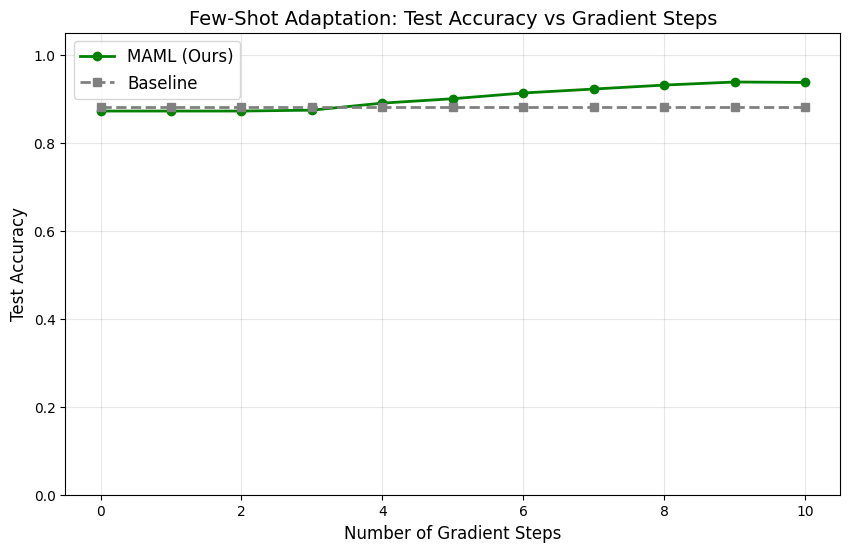

In [8]:

test_center = task_dist.sample_task()
print(f"Test Task Center: {test_center}")

maml_acc, maml_params_final = evaluate_maml(maml_model, test_center, steps=10, k_shot=K_SHOT)
base_acc, base_model_final = evaluate_baseline(baseline_model, test_center, steps=10, k_shot=K_SHOT)

plt.figure(figsize=(10, 6))
plt.plot(range(11), maml_acc, 'o-', label='MAML (Ours)', color='green', linewidth=2)
plt.plot(range(11), base_acc, 's--', label='Baseline', color='gray', linewidth=2)
plt.title('Few-Shot Adaptation: Test Accuracy vs Gradient Steps', fontsize=14)
plt.xlabel('Number of Gradient Steps', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1.05)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()